# Optimize the design of the transmon pocket

To keep the structure roughly the same, we change the width of the metal pad in the transmon pocket. Intuitively, the wider the transmon pocket, the larger the capacitance would be. To increase the qubit frequency, we need to increase the capacitance.

## Steps
1. Construct the function that takes in padwidth and return a capacitance between ground and the metal pad
2. Function that takes in frequency and spit out desired capacitance
3. Optimize and find the desired design

In [47]:

import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [5]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [26]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 

design.delete_all_components()

options = dict(pad_width = '200um',
pocket_width = '300um',
pad_pocket_distance_top = '60um',
pos_x = '0',
pad_height = '200um',
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10um',
             pad_height = '20um',
             pad_width = '100um',
             pad_cpw_extent =  '10um',
             pocket_rise = '0um',
             cpw_extend = '5um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])

In [27]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [28]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [29]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 09:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:56PM [analyze]: Analyzing setup Setup
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1tpi2jws.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_9ly42no.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqgdvg66z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwvply9hr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [30]:
c_mat

,a_connector_pad_Q1,ground_main_plane,pad_top_Q1
a_connector_pad_Q1,23.63791,-13.83121,-9.42478
ground_main_plane,-13.83121,122.84866,-67.19156
pad_top_Q1,-9.42478,-67.19156,80.04586


In [24]:
C = c_mat['ground_main_plane']['a_connector_pad_Q1']

In [25]:
C

-11.46906

In [33]:
def find_Cap(width):
    width = width.to(u.um)
    design.delete_all_components()

    options = dict(pad_width = '{}um'.format(width.value),
    pocket_width = '300um',
    pad_pocket_distance_top = '60um',
    pos_x = '0',
    pad_height = '200um',
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 5
    c1.sim.setup.max_passes = 10
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(c_mat['ground_main_plane']['a_connector_pad_Q1'])
    

In [39]:

widths = np.linspace(70*u.um, 250*u.um, 20)
result = []
for i, width in enumerate(widths):
    result += [find_Cap(width)]


INFO 10:19AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:19AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:19AM [analyze]: Analyzing setup Setup
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpli5lp9qn.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp43vlxlhs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpt15clifc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpf4vp7d8g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            30.02637          -21.06764    -8.26236
ground_main_plane            -21.06764           97.26390   -33.73405
pad_top_Q1                    -8.26236          -33.73405    43.90005


INFO 10:20AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:20AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:20AM [analyze]: Analyzing setup Setup
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp50pjfgtt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvoc68sae.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppxx4mfpq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:20AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3d84p0ws.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.64674          -20.30142    -8.70538
ground_main_plane            -20.30142           99.14463   -36.08575
pad_top_Q1                    -8.70538          -36.08575    46.82482


INFO 10:20AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:20AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:20AM [analyze]: Analyzing setup Setup
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp19elb8fd.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaaal35ov.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8xmec1fg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm6tvez9m.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.40395          -19.63996    -9.15391
ground_main_plane            -19.63996          100.79371   -38.48791
pad_top_Q1                    -9.15391          -38.48791    49.79939


INFO 10:21AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:21AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:21AM [analyze]: Analyzing setup Setup
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzosliekn.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkza3zujg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3djf0yi4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:21AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppcz9emrp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.05364          -19.00889    -9.46223
ground_main_plane            -19.00889          102.47861   -40.89040
pad_top_Q1                    -9.46223          -40.89040    52.62968


INFO 10:21AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:21AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:21AM [analyze]: Analyzing setup Setup
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2h0u0gwu.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgosxw6wn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr6imgva7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5u2y4a1g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            29.02177          -18.54246    -9.89995
ground_main_plane            -18.54246          104.00923   -43.64347
pad_top_Q1                    -9.89995          -43.64347    55.97483


INFO 10:22AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:22AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:22AM [analyze]: Analyzing setup Setup
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc836cbys.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmwi0z01g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp52cbvmt6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:22AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw5yhoe2w.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            28.62239          -18.00099   -10.06615
ground_main_plane            -18.00099          105.83737   -46.11199
pad_top_Q1                   -10.06615          -46.11199    58.73271


INFO 10:22AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:22AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:22AM [analyze]: Analyzing setup Setup
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpiqs9pa0a.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpuf5prabv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpovzmovip.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkfb37aw9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            28.15453          -17.46411   -10.15847
ground_main_plane            -17.46411          107.64287   -48.54272
pad_top_Q1                   -10.15847          -48.54272    61.37314


INFO 10:23AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:23AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:23AM [analyze]: Analyzing setup Setup
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpion6ag6n.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdr8unjw9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnizj4vup.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:23AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpojqjcx0g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            27.40389          -16.85643   -10.05632
ground_main_plane            -16.85643          109.91602   -50.83337
pad_top_Q1                   -10.05632          -50.83337    63.63738


INFO 10:23AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:23AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:23AM [analyze]: Analyzing setup Setup
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3i7g5t1i.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7wqc2cu5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzzxuc6wz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsent837i.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            27.25024          -16.55293   -10.20564
ground_main_plane            -16.55293          111.69824   -53.69843
pad_top_Q1                   -10.20564          -53.69843    66.81339


INFO 10:24AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:24AM [analyze]: Analyzing setup Setup
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmarfijgn.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbn45hxac.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnrzgqxmp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:24AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgx4leuyw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            26.79435          -16.11864   -10.20245
ground_main_plane            -16.11864          113.68610   -56.21173
pad_top_Q1                   -10.20245          -56.21173    69.43782


INFO 10:25AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:25AM [analyze]: Analyzing setup Setup
INFO 10:25AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppbf0va5h.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:25AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjn421tbg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:25AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2n6l2xwo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:25AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpuf88y0i7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            26.28633          -15.63358   -10.19919
ground_main_plane            -15.63358          115.85467   -58.81903
pad_top_Q1                   -10.19919          -58.81903    72.13739


INFO 10:25AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:25AM [analyze]: Analyzing setup Setup
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpi9ef8czt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppiulmj5g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbyblj28n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpucq88om7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            25.81701          -15.26496   -10.11383
ground_main_plane            -15.26496          118.02553   -61.49914
pad_top_Q1                   -10.11383          -61.49914    74.84580


INFO 10:26AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:26AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:26AM [analyze]: Analyzing setup Setup
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_la6708a.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbhbsuh7u.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdr0fwrqt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7xwbhy30.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            25.39820          -14.89732   -10.07828
ground_main_plane            -14.89732          120.26723   -64.23112
pad_top_Q1                   -10.07828          -64.23112    77.65260


INFO 10:26AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:26AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:26AM [analyze]: Analyzing setup Setup
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1i9d2itp.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7q4m00nf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvrgzevyn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvy6cd4c9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            24.92206          -14.47184   -10.04393
ground_main_plane            -14.47184          122.64104   -67.04932
pad_top_Q1                   -10.04393          -67.04932    80.54139


INFO 10:27AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:27AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:27AM [analyze]: Analyzing setup Setup
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw2g122lp.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpacg3uh4s.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbk8iqgg9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:27AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvcmn5ztj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            24.40968          -14.06320    -9.95539
ground_main_plane            -14.06320          125.01854   -69.90503
pad_top_Q1                    -9.95539          -69.90503    83.41049


INFO 10:27AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:27AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:27AM [analyze]: Analyzing setup Setup
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpszg17jpl.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprgbr623r.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvr9y1d0z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdnqwnbkb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.96760          -13.70277    -9.88705
ground_main_plane            -13.70277          127.55997   -72.86716
pad_top_Q1                    -9.88705          -72.86716    86.40452


INFO 10:28AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:28AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:28AM [analyze]: Analyzing setup Setup
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpb2oyy1i_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqqzdaj4l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppavlin_h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:28AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdawbnyj6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.53710          -13.36687    -9.80565
ground_main_plane            -13.36687          130.20927   -76.05826
pad_top_Q1                    -9.80565          -76.05826    89.61791


INFO 10:28AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:28AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:28AM [analyze]: Analyzing setup Setup
INFO 10:29AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpve022h8e.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:29AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm8r32cuh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:29AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcqvfzag5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:29AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfmgokwuj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.08780          -13.02276    -9.71309
ground_main_plane            -13.02276          133.13832   -79.42955
pad_top_Q1                    -9.71309          -79.42955    92.99271


INFO 10:29AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:29AM [analyze]: Analyzing setup Setup
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp64t9yu7z.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe0szx_dt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpx0va3erp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdasz_zn8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.60001          -12.66453    -9.59539
ground_main_plane            -12.66453          136.42882   -83.16008
pad_top_Q1                    -9.59539          -83.16008    96.70038


INFO 10:30AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:30AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:30AM [analyze]: Analyzing setup Setup
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqk_zwdlp.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpt04y5ins.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp47nqlft4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq8ns174l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.18129          -12.35845    -9.49355
ground_main_plane            -12.35845          139.88913   -87.00096
pad_top_Q1                    -9.49355          -87.00096   100.52529


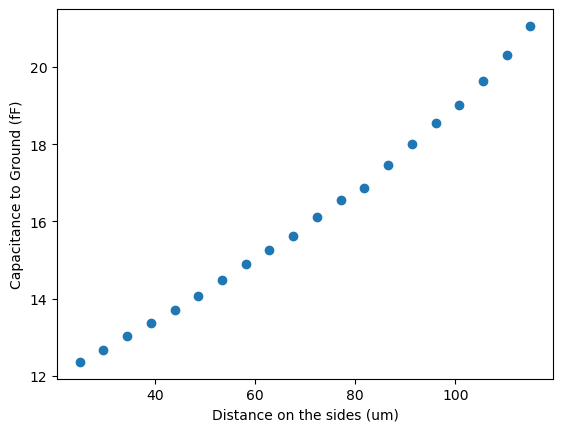

In [67]:
plt.scatter((300*u.um-widths)/2, -np.array(result))
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

In [56]:
def find_Cap(height):
    height = height.to(u.um)
    design.delete_all_components()

    options = dict(pad_width = '250um',
    pocket_width = '300um',
    pad_pocket_distance_top = '60um',
    pos_x = '0',
    pad_height = '{}um'.format(height.value),
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 5
    c1.sim.setup.max_passes = 10
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(c_mat)

In [69]:
heights = np.linspace(70*u.um, 240*u.um, 15)
result_height = []
for height in heights:
    result_height += [find_Cap(height)]

INFO 11:44AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:44AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:44AM [analyze]: Analyzing setup Setup
INFO 11:44AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp8g7zpx1.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:44AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsxseccw2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:44AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppenfxbrk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:44AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0p_5qgx7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.19276          -12.93651    -8.88867
ground_main_plane            -12.93651          100.95584   -49.06611
pad_top_Q1                    -8.88867          -49.06611    59.90882


INFO 11:44AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:45AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:45AM [analyze]: Analyzing setup Setup
INFO 11:45AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgkg7j6au.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:45AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptwpidork.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:45AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfet23y1n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:45AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvzspoz8i.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.20452          -12.84187    -9.00830
ground_main_plane            -12.84187          105.03039   -53.13794
pad_top_Q1                    -9.00830          -53.13794    64.32843


INFO 11:45AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:45AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:45AM [analyze]: Analyzing setup Setup
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu77yucuv.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp4qa5f0cs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkcxd4lz3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc9vvpro0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.18034          -12.75395    -9.08679
ground_main_plane            -12.75395          108.92505   -56.97987
pad_top_Q1                    -9.08679          -56.97987    68.46049


INFO 11:46AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:46AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:46AM [analyze]: Analyzing setup Setup
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpabd_79mq.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsecshilj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphceiv_np.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:46AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm2zzjlbl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.20622          -12.68861    -9.19873
ground_main_plane            -12.68861          112.72248   -60.65092
pad_top_Q1                    -9.19873          -60.65092    72.45453


INFO 11:46AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:46AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:46AM [analyze]: Analyzing setup Setup
INFO 11:47AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaul0ktl7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:47AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnuw3izpu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:47AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpotpw_6p9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:47AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1m811ffm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.19789          -12.64350    -9.24254
ground_main_plane            -12.64350          116.43674   -64.25438
pad_top_Q1                    -9.24254          -64.25438    76.29707


INFO 11:47AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:47AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:47AM [analyze]: Analyzing setup Setup
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjt5qokj0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu6dinjbn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp42pw8mhs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl5g90q1r.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.18662          -12.57052    -9.29372
ground_main_plane            -12.57052          120.03806   -67.76506
pad_top_Q1                    -9.29372          -67.76506    80.04217


INFO 11:48AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:48AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:48AM [analyze]: Analyzing setup Setup
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcxjhgywg.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfwtgiyc0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptxmh5g1v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:48AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpamjmn_w6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.17248          -12.49289    -9.34469
ground_main_plane            -12.49289          123.68223   -71.24226
pad_top_Q1                    -9.34469          -71.24226    83.73809


INFO 11:48AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:48AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:48AM [analyze]: Analyzing setup Setup
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwsetefr4.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu7ru6jxr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxojmb525.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv_czlb79.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.17981          -12.45968    -9.38172
ground_main_plane            -12.45968          127.15165   -74.67203
pad_top_Q1                    -9.38172          -74.67203    87.39928


INFO 11:49AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:49AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:49AM [analyze]: Analyzing setup Setup
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp25uzjfbw.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9zw51x_e.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_wml_g1c.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy8dbu513.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.15304          -12.42103    -9.39176
ground_main_plane            -12.42103          130.65641   -78.08556
pad_top_Q1                    -9.39176          -78.08556    91.00439


INFO 11:49AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:50AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:50AM [analyze]: Analyzing setup Setup
INFO 11:50AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6z1b0zf9.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:50AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp27cw5ypk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:50AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3wcs22z3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:50AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpau4nam15.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.14112          -12.39473    -9.40828
ground_main_plane            -12.39473          134.07255   -81.38544
pad_top_Q1                    -9.40828          -81.38544    94.50956


INFO 11:50AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:50AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:50AM [analyze]: Analyzing setup Setup
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdds0dqi1.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkyyqo51s.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6u93puhu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3x5e6qwp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.14579          -12.36362    -9.44900
ground_main_plane            -12.36362          137.51739   -84.69954
pad_top_Q1                    -9.44900          -84.69954    98.04613


INFO 11:51AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:51AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:51AM [analyze]: Analyzing setup Setup
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr25d0czx.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplmqw_2vo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz_nfa5fr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:51AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwbtu2mm9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.17021          -12.34886    -9.49556
ground_main_plane            -12.34886          140.83666   -87.89636
pad_top_Q1                    -9.49556          -87.89636   101.47174


INFO 11:51AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:51AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:51AM [analyze]: Analyzing setup Setup
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm28r_m5q.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp4g_gfn17.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1h0h8jy1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp590y_07f.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.11539          -12.30617    -9.48960
ground_main_plane            -12.30617          144.32066   -91.18205
pad_top_Q1                    -9.48960          -91.18205   104.93007


INFO 11:52AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:52AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:52AM [analyze]: Analyzing setup Setup
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2grvt7uc.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphemf0ign.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7ijlgi7v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:52AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgmmphen7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.16548          -12.32559    -9.52531
ground_main_plane            -12.32559          147.68379   -94.45887
pad_top_Q1                    -9.52531          -94.45887   108.41359


INFO 11:52AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:52AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:52AM [analyze]: Analyzing setup Setup
INFO 11:53AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1209ynnk.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:53AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkddtka5d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:53AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgv5_38hy.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:53AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6l6f9sna.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.19617          -12.33450    -9.55050
ground_main_plane            -12.33450          151.03771   -97.68446
pad_top_Q1                    -9.55050          -97.68446   111.82653


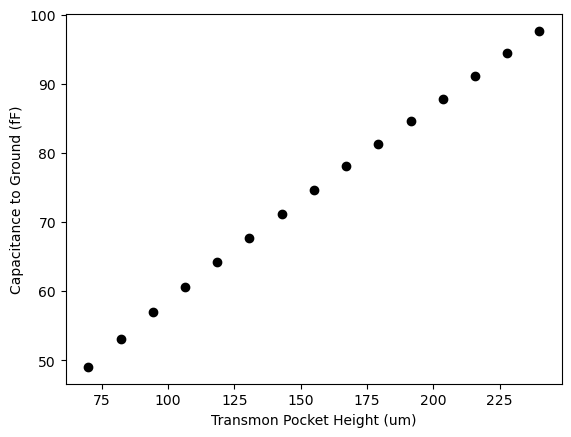

In [70]:
for i, r in enumerate(result_height):
    plt.scatter(heights[i], -r['pad_top_Q1']['ground_main_plane'],color = 'black')
plt.xlabel('Transmon Pocket Height (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

In [ ]:
plt.scatter(heights, -np.array(result))
